In [73]:
# Standard library imports
from datetime import time, datetime, timedelta
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from tqdm import tqdm
from joblib import Parallel, delayed

# Local imports
from helper_code import *
from team_code import *
from segment_quality_evaluation import process_EEG

from FMMFeatureExtractor import FMMFeatureExtractor
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from helper_code import load_recording_data

import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy.stats import circmean, circstd

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib as mpl

# Set global matplotlib config for bold axis labels
mpl.rcParams['axes.labelweight'] = 'bold'

# autoreload changes in helper_code and team_code
%load_ext autoreload
%autoreload 2


# Get the start time (as a time object) from the recording data.
def get_start_time_triplet(string):
    variable = get_variable(string, '#Start time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

# Get the end time (as a time object) from the recording data.
def get_end_time_triplet(string):
    variable = get_variable(string, '#End time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

DATA_FOLDER = "../data/"
ROOT_FOLDER = DATA_FOLDER+ "physionet.org/files/i-care/2.1/training"
TRAIN_HOSPITALS = ['A', 'B', 'E']
TEST_HOSPITALS = ['D', 'F']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Adolfo\AppData\Local\Temp\ipykernel_21144\1651742223.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked.set_montage(custom_montage)


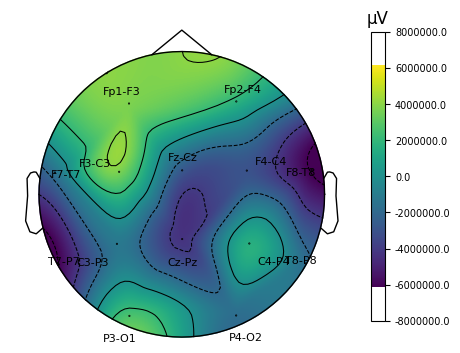

In [3]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Pares bipolares: (canal1, canal2)
pares_bipolares = [
    ('Fp1', 'F3'), ('Fp2', 'F4'), ('F3', 'C3'), ('F4', 'C4'),
    ('C3', 'P3'), ('C4', 'P4'), ('P3', 'O1'), ('P4', 'O2'),
    ('F7', 'T7'), ('F8', 'T8'), ('T7', 'P7'), ('T8', 'P8'),
    ('Fz', 'Cz'), ('Cz', 'Pz')
]

# Genera valores simulados para los electrodos individuales
electrodos_unicos = list(set([e for par in pares_bipolares for e in par]))
valores_individuales = dict(zip(electrodos_unicos, np.random.rand(len(electrodos_unicos)) * 10))

# Calcula diferencias bipolares
valores_bipolares = np.array([
    valores_individuales[e1] - valores_individuales[e2]
    for (e1, e2) in pares_bipolares
])

# Nombres de los canales bipolares
nombres_bipolares = [f'{e1}-{e2}' for (e1, e2) in pares_bipolares]

# Montaje estándar y posiciones
montaje = mne.channels.make_standard_montage('standard_1020')
montaje_positions = montaje.get_positions()['ch_pos']

# Calcula posiciones promedio para cada canal bipolar
posiciones_bipolares = np.array([
    (montaje_positions[e1] + montaje_positions[e2]) / 2
    for (e1, e2) in pares_bipolares
])
pos_dict = dict(zip(nombres_bipolares, posiciones_bipolares))

# Crea info y EvokedArray
info = mne.create_info(ch_names=nombres_bipolares, sfreq=1000, ch_types='eeg')
evoked = mne.EvokedArray(np.expand_dims(valores_bipolares, axis=1), info)

# Crea montaje personalizado con las posiciones promedio
custom_montage = mne.channels.make_dig_montage(ch_pos=pos_dict)
evoked.set_montage(custom_montage)

# Graficar topomap con labels
fig = evoked.plot_topomap(times=0, size=3, cmap='viridis', time_format='', show=False)

# Añade etiquetas de canal a la figura
ax = fig.axes[0]
for name, pos in pos_dict.items():
    # Solo usa las primeras dos dimensiones (x, y)
    x, y = pos[:2]
    ax.text(x, y, name, fontsize=8, ha='center', va='center', color='black')

plt.show()


In [4]:
def segmentos_5_minutos(start: time, end: time):
    # Convertir a datetime para facilitar los cálculos
    start_dt = datetime(2000, 1, 1, start.hour, start.minute, start.second)
    end_dt = datetime(2000, 1, 1, end.hour, end.minute, end.second)
    
    # Ajustar el inicio al siguiente múltiplo de 5 minutos
    start_min = (start_dt.minute // 5) * 5
    if start_dt.minute % 5 != 0 or start_dt.second > 0:
        start_min += 5
    
    # Controlar si start_min se vuelve 60 y ajustar la hora
    if start_min == 60:
        start_segment = datetime(2000, 1, 1, start_dt.hour + 1, 0, 0)
    else:
        start_segment = datetime(2000, 1, 1, start_dt.hour, start_min, 0)
    
    # Lista de segmentos
    segments = []
    
    while start_segment + timedelta(minutes=5) - timedelta(seconds=1) <= end_dt:
        end_minute = start_segment.minute + 4
        end_hour = start_segment.hour
        if end_minute >= 60:
            end_minute -= 60
            end_hour += 1
        
        segments.append((
            time(start_segment.hour, start_segment.minute, 0),
            time(end_hour, end_minute, 59)
        ))
        start_segment += timedelta(minutes=5)
    
    return segments

def dividir_dataframe_en_segmentos(df, start: time, end: time, sampling_frequency: int):
    samples_per_5_min = sampling_frequency * 5 * 60
    start_times = []
    end_times = []

    # If len is less that 5min do early return
    if len(df) < samples_per_5_min:
        return start_times, end_times

    segments = segmentos_5_minutos(start, end)

    return segments

In [5]:
# Definir los tiempos de inicio y fin
start_time = time(23, 00, 0)
end_time = time(23, 59, 59)

# Crear un DataFrame de ejemplo con sampling_frequency de 128
sampling_frequency = 128  # 128 observaciones por segundo
total_seconds = (datetime(2000, 1, 1, end_time.hour, end_time.minute, end_time.second) - 
                 datetime(2000, 1, 1, start_time.hour, start_time.minute, start_time.second)).total_seconds()
data = {"col1": range(int(total_seconds * sampling_frequency)), "col2": range(int(total_seconds * sampling_frequency))}
df = pd.DataFrame(data)

# Obtener sub DataFrames
segments = dividir_dataframe_en_segmentos(df, start_time, end_time, sampling_frequency)

# Imprimir cada sub DataFrame
for i, (start_frag, end_frag) in enumerate(segments):
    print(f"Segmento {i + 1} (Inicio: {start_frag}, Fin: {end_frag}):")

Segmento 1 (Inicio: 23:00:00, Fin: 23:04:59):
Segmento 2 (Inicio: 23:05:00, Fin: 23:09:59):
Segmento 3 (Inicio: 23:10:00, Fin: 23:14:59):
Segmento 4 (Inicio: 23:15:00, Fin: 23:19:59):
Segmento 5 (Inicio: 23:20:00, Fin: 23:24:59):
Segmento 6 (Inicio: 23:25:00, Fin: 23:29:59):
Segmento 7 (Inicio: 23:30:00, Fin: 23:34:59):
Segmento 8 (Inicio: 23:35:00, Fin: 23:39:59):
Segmento 9 (Inicio: 23:40:00, Fin: 23:44:59):
Segmento 10 (Inicio: 23:45:00, Fin: 23:49:59):
Segmento 11 (Inicio: 23:50:00, Fin: 23:54:59):
Segmento 12 (Inicio: 23:55:00, Fin: 23:59:59):


In [6]:
data_folder = ROOT_FOLDER
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)
current_features = None
GROUP = 'EEG'

def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def resample_segment(data, original_sampling_frequency, target_sampling_frequency):
    num_samples = int(data.shape[1] * target_sampling_frequency / original_sampling_frequency)
    resampled_data = resample(data, num_samples, axis=1)
    return resampled_data

In [7]:
N_HOURS = 12

MIN_MINUTES = 5
DROP_MEAN_STD = 0
DOUBLE_BANANA = [
        ("Fp1", "F7"), ("F7", "T3"), ("T3", "T5"), ("T5", "O1"),  # Left temporal chain
        ("Fp2", "F8"), ("F8", "T4"), ("T4", "T6"), ("T6", "O2"),  # Right temporal chain
        ("Fp1", "F3"), ("F3", "C3"), ("C3", "P3"), ("P3", "O1"),  # Left parasagittal chain
        ("Fp2", "F4"), ("F4", "C4"), ("C4", "P4"), ("P4", "O2"),  # Right parasagittal chain
        ("Fz", "Cz"), ("Cz", "Pz")                                # Central chain
]
BANDPASS_FREQS = [0.1, 45.0]
TARGET_SAMPLING_FREQUENCY = 128 # Nyquist

In [8]:
len(DOUBLE_BANANA)

18

In [9]:
rec_loc = "../data/physionet.org/files/i-care/2.1/training/0284/0284_010_012_EEG"
# read a eeg file
data, channels, sampling_frequency = load_recording_data(rec_loc)
utility_frequency = get_utility_frequency(rec_loc + ".hea")
data, sampling_frequency = preprocess_data(
            data, sampling_frequency, utility_frequency, channels
        )
data = get_bipolar_data(data)  # Create double-banana montage
data.shape

(57344, 18)

## Classification

In [10]:
features_folder = os.path.join(DATA_FOLDER, "features_classical")
features_files = [f for f in os.listdir(features_folder) if f.endswith(".csv")]
features_dfs = [pd.read_csv(os.path.join(features_folder, f), dtype={"patient_id": str}) for f in features_files]
df_features_classical = pd.concat(features_dfs, axis=0)
# sort by patient_id and start_time
df_features_classical = df_features_classical.sort_values(by=["patient_id", "start_time"], ascending=True)
df_features_classical.insert(1, "hour", df_features_classical["start_time"].str.split(":").str[0].astype(int))
print(df_features_classical.shape)

(232170, 225)


In [11]:
features_folder = os.path.join(DATA_FOLDER, "features_fmm")
features_files = [f for f in os.listdir(features_folder) if f.endswith(".csv")]
features_dfs = [pd.read_csv(os.path.join(features_folder, f), dtype={"patient_id": str}) for f in features_files]
df_features_fmm = pd.concat(features_dfs, axis=0)

# # sort by patient_id and start_time
df_features_fmm = df_features_fmm.sort_values(by=["patient_id", "start_time"], ascending=True)
df_features_fmm.insert(1, "hour", df_features_fmm["start_time"].str.split(":").str[0].astype(int))
print(df_features_fmm.shape)

(2321700, 27)


In [12]:
def coef_var(x):
    mean_x = np.mean(x)
    return np.std(x) / mean_x if mean_x != 0 else np.nan




def preprocess_fmm_data(df_features_fmm):
    df_features_fmm2 = df_features_fmm.copy()

    # Select columns with '_A_' in the name
    a_cols = [col for col in df_features_fmm2.columns if "_A_" in col]

    # Compute the row-wise median for those columns
    df_features_fmm2["FMM_A_me"] = df_features_fmm2[a_cols].median(axis=1)

    # Aggregate by patient_id, start_time, and epoch_num
    agg = df_features_fmm2.groupby(["patient_id", "start_time", "epoch_num"]).agg(
        hour=("hour", "first"),
        FMM_A_me_mean=("FMM_A_me", "mean"),
        FMM_A_me_sd=("FMM_A_me", "std"),
        FMM_ω_mean=("FMM_ω", "mean"),
        FMM_ω_sd=("FMM_ω", "std"),
        FMM_R2_median=("FMM_R2", "median"),
    )

    # Compute Coefficient of Variation (CV)
    agg["FMM_A_me_cv"] = agg["FMM_A_me_sd"] / agg["FMM_A_me_mean"].replace(0, np.nan)
    agg["FMM_ω_cv"] = agg["FMM_ω_sd"] / agg["FMM_ω_mean"].replace(0, np.nan)

    # Circular statistics for FMM_α
    grouped = df_features_fmm2.groupby(["patient_id", "start_time", "epoch_num"])["FMM_α"]
    agg["FMM_α_circmean"] = grouped.apply(lambda x: circmean(x, high=2 * np.pi, low=0))
    agg["FMM_α_circsd"] = grouped.apply(lambda x: circstd(x, high=2 * np.pi, low=0))
    agg["FMM_α_circcv"] = agg["FMM_α_circsd"] / agg["FMM_α_circmean"].replace(0, np.nan)

    # Proportion of waves with FMM_ω < 0.01
    agg["FMM_ω_proplt001"] = df_features_fmm2.groupby(
        ["patient_id", "start_time", "epoch_num"]
    )["FMM_ω"].apply(lambda x: (x < 0.01).mean())

    # Reset index to return a flat DataFrame
    agg = agg.reset_index()

    #agg = pd.merge(df_features_fmm2, agg, on=["patient_id", "start_time", "epoch_num"], how="left") # TODO


    return agg


In [13]:
def preprocess_classical_data(df_features_classical: pd.DataFrame) -> pd.DataFrame:
    BASICS = ["patient_id", "hour", "start_time", "end_time", "epoch_num"]
    df = df_features_classical.copy()

    # 1. Renombrar "_std" → "_sd"
    df.columns = [col.replace("_std", "_sd") for col in df.columns]

    # 2. Eliminar columnas que no sean mean/sd/cv, excepto 'hour'
    cols_to_keep = [
        col
        for col in df.columns
        if col.endswith(("_mean", "_sd", "_cv")) or col in BASICS
    ]
    df = df[cols_to_keep]

    # 3. Calcular CV = sd / mean
    for col in df.columns:
        if col.endswith("_sd"):
            prefix = col[:-3]
            mean_col = prefix + "_mean"
            if mean_col in df.columns:
                cv_col = prefix + "_cv"
                df[cv_col] = df[col] / df[mean_col].replace(0, np.nan)

    return df

In [14]:
def aggregate_features_variable_blocks(df, block_size=4):
    df = df.copy()
    # Calcular bloque horario según block_size
    df["hour_block_start"] = (df["hour"] // block_size) * block_size

    group_cols = ["patient_id", "hour_block_start"]
    feature_cols = df.columns.difference(["patient_id", "hour", "hour_block_start"])

    agg = df.groupby(group_cols)[feature_cols].median().reset_index()

    # Pivot para tener bloques como columnas
    agg_pivot = agg.pivot(index="patient_id", columns="hour_block_start")[feature_cols]

    # Construir sufijo dinámico según hora final del bloque
    agg_pivot.columns = [
        f"{feat}_{int(block_start + block_size )}H"
        for feat, block_start in agg_pivot.columns
    ]

    # Resetear índice
    agg_final = agg_pivot.reset_index()

    return agg_final

In [15]:
df_features_classical_proc = preprocess_classical_data(df_features_classical)
df_features_classical_proc

,patient_id,hour,start_time,end_time,epoch_num,ENT_perm_mean,ENT_perm_sd,ENT_spectral_mean,ENT_spectral_sd,ENT_svd_mean,...,ENT_spectral_cv,ENT_svd_cv,FRC_higuchi_cv,FRC_petrosian_cv,FRC_katz_cv,SPC_delta_cv,SPC_theta_cv,SPC_alpha_cv,SPC_beta_cv,SPC_gamma_cv
0,0284,4,04:10:00,04:14:59,1,0.981071,0.017866,0.474342,0.078346,0.470768,...,0.165167,0.219183,0.036526,0.003858,0.123927,0.151559,0.386323,0.387193,0.358756,0.421475
1,0284,4,04:10:00,04:14:59,2,0.972064,0.027700,0.444913,0.137619,0.452253,...,0.309315,0.339845,0.114265,0.005635,0.173498,0.178130,0.823121,0.781456,0.875828,0.911295
2,0284,4,04:10:00,04:14:59,3,0.983775,0.015875,0.559281,0.105420,0.543602,...,0.188493,0.278237,0.038043,0.004375,0.140405,0.180547,0.332213,0.356121,0.338922,0.402358
3,0284,4,04:10:00,04:14:59,4,0.983242,0.015982,0.538928,0.114359,0.535812,...,0.212197,0.231431,0.057594,0.003998,0.158469,0.199616,0.394168,0.397166,0.420526,0.443775
4,0284,4,04:10:00,04:14:59,5,0.982800,0.014184,0.480856,0.069853,0.469478,...,0.145268,0.163988,0.035520,0.003323,0.084240,0.148286,0.339279,0.316332,0.465382,0.502088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1020,23,23:15:00,23:19:59,26,0.985945,0.007522,0.767019,0.160314,0.981276,...,0.209010,0.022551,0.029969,0.004165,1.436118,0.419679,0.783836,0.242284,0.078482,0.200116
236,1020,23,23:15:00,23:19:59,27,0.987401,0.006649,0.776444,0.170741,0.982167,...,0.219901,0.023135,0.030792,0.003961,1.635593,0.440276,0.745594,0.317432,0.094351,0.192060
237,1020,23,23:15:00,23:19:59,28,0.986893,0.007197,0.771244,0.170584,0.979499,...,0.221181,0.023171,0.031499,0.004196,1.385169,0.486568,0.674578,0.298251,0.102703,0.226972
238,1020,23,23:15:00,23:19:59,29,0.988384,0.005961,0.761843,0.167264,0.980030,...,0.219551,0.023554,0.029505,0.003992,1.416095,0.395605,0.751383,0.297748,0.111534,0.217390


In [16]:
df_features_fmm_proc = preprocess_fmm_data(df_features_fmm)
df_features_fmm_proc

,patient_id,start_time,epoch_num,hour,FMM_A_me_mean,FMM_A_me_sd,FMM_ω_mean,FMM_ω_sd,FMM_R2_median,FMM_A_me_cv,FMM_ω_cv,FMM_α_circmean,FMM_α_circsd,FMM_α_circcv,FMM_ω_proplt001
0,0284,04:10:00,1,4,0.517049,0.409671,0.173146,0.144985,0.045146,0.792325,0.837358,4.028316,1.279186,0.317549,0.1
1,0284,04:10:00,2,4,0.212585,0.204069,0.184969,0.163810,0.036806,0.959941,0.885607,1.167588,1.267999,1.085998,0.1
2,0284,04:10:00,3,4,0.268576,0.062923,0.086004,0.119073,0.043882,0.234283,1.384511,2.460566,0.655675,0.266473,0.1
3,0284,04:10:00,4,4,0.628202,0.513393,0.192556,0.136847,0.029675,0.817242,0.710688,3.730002,1.728986,0.463535,0.1
4,0284,04:10:00,5,4,0.524404,0.183529,0.227583,0.144547,0.066603,0.349977,0.635141,2.436559,1.592050,0.653401,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232165,1020,23:15:00,26,23,0.112645,0.073731,0.092981,0.125472,0.005595,0.654547,1.349425,3.679883,2.599409,0.706383,0.6
232166,1020,23:15:00,27,23,0.045906,0.015649,0.086696,0.097252,0.040703,0.340901,1.121755,4.150641,1.980736,0.477212,0.5
232167,1020,23:15:00,28,23,0.589513,0.846124,0.108501,0.125071,0.060371,1.435293,1.152716,3.717190,1.273361,0.342560,0.5
232168,1020,23:15:00,29,23,0.140710,0.136300,0.079931,0.101021,0.024089,0.968664,1.263843,3.059846,1.255402,0.410283,0.5


In [17]:
import pandas as pd

def topn_filter(df, column="hour", N=2, keep_n_epochs=True):
    # Paso 1: Para cada paciente, obtener las N horas más altas (sin duplicados)
    top_hours_per_patient = (
        df.groupby('patient_id')[column]
        .apply(lambda x: x.drop_duplicates(keep='last').nlargest(N))
        .reset_index()
    )
    top_hours_per_patient.rename(columns={"level_1": "n_epochs"}, inplace=True)
    if not keep_n_epochs:
        top_hours_per_patient = top_hours_per_patient.drop(columns=["n_epochs"])
    # df_filtered = df.merge(top_hours_per_patient[['patient_id', column]], on=['patient_id', column])
    df_filtered = df.merge(top_hours_per_patient, on=['patient_id', column])
    return df_filtered

In [18]:
import pandas as pd
import re

def missing_percentage_by_hour_group(df):
    # Diccionario para almacenar grupos: clave = número horas, valor = lista columnas
    groups = {}

    # Expresión regular para detectar columnas que terminan en número + H
    pattern = re.compile(r'(\d+)H$')

    for col in df.columns:
        match = pattern.search(col)
        if match:
            hours = int(match.group(1))
            groups.setdefault(hours, []).append(col)

    # Calcular porcentaje missing por grupo
    missing_pct = {}
    for hours, cols in groups.items():
        # porcentaje missing promedio en las columnas de ese grupo
        missing_pct[hours] = df[cols].isna().mean().mean() * 100  # en %

    # Convertir a DataFrame para mejor presentación y ordenar por horas
    result = pd.DataFrame.from_dict(missing_pct, orient='index', columns=['missing_pct']).sort_index()

    return result

In [19]:
def aggregate_features_variable_blocks(df, block_size=4):
    df = df.copy()
    # Calcular bloque horario según block_size
    df["hour_block_start"] = (df["hour"] // block_size) * block_size

    group_cols = ["patient_id", "hour_block_start"]
    feature_cols = df.columns.difference(["patient_id", "hour", "hour_block_start"])

    agg = df.groupby(group_cols)[feature_cols].median().reset_index()

    # Pivot para tener bloques como columnas
    agg_pivot = agg.pivot(index="patient_id", columns="hour_block_start")[feature_cols]

    # Construir sufijo dinámico según hora final del bloque
    agg_pivot.columns = [
        f"{feat}_{int(block_start + block_size )}H"
        for feat, block_start in agg_pivot.columns
    ]

    # Resetear índice
    agg_final = agg_pivot.reset_index()

    return agg_final

In [20]:
def prepare_datasets(
    X_clinical: pd.DataFrame,
    df_features_classical: pd.DataFrame,
    df_features_fmm: pd.DataFrame,
    epoch_subset: pd.DataFrame,
    filter_column: str,
    test_hospitals: list = TEST_HOSPITALS,
    block_size: int = 4,
    N=3,
    max_hours=24
):
    COLS2DROP = ["outcome", "patient_id", "hospital", "outcome", "cpcs"]

    X = X_clinical.copy()
    #X["sex"] = X["sex"].astype("category")
    X["sex"] = (X["sex"] == "Female").astype(int)
    
    n_total = X_clinical["patient_id"].nunique()
    n_withdata = df_features_fmm["patient_id"].nunique()
    discard_perc = (n_total - n_withdata) / n_total * 100
    #print(f"{n_total - n_withdata=}")

    ### Filtrar por epoch_subset (solo filas donde `filter_column` sea True)
    key_cols = ["patient_id", "start_time"]
    filtered_epochs = epoch_subset[key_cols]
    filtered_epochs = filtered_epochs[epoch_subset[filter_column] == True]
    


    # Merge de classical features
    
    # TODO
    subdf_classical = pd.merge(
        df_features_classical, filtered_epochs, on=key_cols, how="inner"
    )
    subdf_classical = subdf_classical[subdf_classical["hour"]  < max_hours]

    subdf_classical["hour_block_start"] = (subdf_classical["hour"] // block_size) * block_size
    subdf_classical = topn_filter(subdf_classical, column="hour_block_start", N=N, keep_n_epochs=True)
    subdf_classical = subdf_classical.drop(columns=["hour_block_start"], errors='ignore')

    subdf_classical = subdf_classical.drop(columns=["hour","start_time", "end_time", "epoch_num"], errors='ignore')
    subdf_classical = subdf_classical.groupby("patient_id").median().reset_index()
    how = "left" if max_hours<24 else "right"
    X = pd.merge(X, subdf_classical, on="patient_id", how=how)

    # Merge de FMM features
    subdf_fmm = df_features_fmm.copy()
    subdf_fmm = subdf_fmm[subdf_fmm["hour"] < max_hours]
    # TODO
    subdf_fmm = pd.merge(
        df_features_fmm, filtered_epochs, on=key_cols, how="inner"
    )
    
    print(subdf_fmm.shape)
    subdf_fmm["hour_block_start"] = (subdf_fmm["hour"] // block_size) * block_size
    subdf_fmm = topn_filter(subdf_fmm, column="hour_block_start", N=N, keep_n_epochs=False)
    subdf_fmm = subdf_fmm.drop(columns=["hour_block_start"], errors='ignore')
    print(subdf_fmm.shape)

    subdf_fmm = subdf_fmm.drop(columns=["hour","start_time", "end_time", "epoch_num"], errors='ignore')
    subdf_fmm = subdf_fmm.groupby("patient_id").median().reset_index()
    X = pd.merge(X, subdf_fmm, on="patient_id", how="left")

    # Separar en train_val y test
    X_train_val = X[~X["hospital"].isin(test_hospitals)].copy()
    y_train_val = X_train_val["outcome"]
    groups_train_val = X_train_val["hospital"]
    X_train_val = X_train_val.drop(columns=COLS2DROP, errors='ignore')

    X_test = X[X["hospital"].isin(test_hospitals)].copy()
    y_test = X_test["outcome"]
    groups_test = X_test["hospital"]
    X_test = X_test.drop(columns=COLS2DROP, errors='ignore')

    
    return X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test

In [21]:
def create_pipeline(df, classifier=None, random_state=42):
    
    if classifier is None:
        classifier = LGBMClassifier(
                    random_state=random_state,
                    verbose=-1,
                    n_jobs=10,
                    # **{"colsample_bytree":0.6208042413288728,
                    # "learning_rate":0.2831145404585005,
                    # "max_depth":9,
                    # "n_estimators":163,
                    # "num_leaves":49,
                    # "subsample":0.866509278372388}
                    
                    
                    **{"colsample_bytree":0.5450311443835689,
                    "learning_rate":0.2652832417281156,
                    "max_depth":10,
                    "n_estimators":200,
                    "num_leaves":64,
                    "subsample":0.921136265542184}
                )
    
    numerical_features = df.select_dtypes(include=["float64", "int64"]).columns
    categorical_features = df.select_dtypes(include=["object"]).columns

    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),  # Handle missing values
            #('scaler', StandardScaler())                 # Scale numerical values
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(strategy="most_frequent"),
            ),  # Handle missing values
            (
                "onehot",
                OneHotEncoder(handle_unknown="ignore"),
            ),  # One-hot encode categorical values
        ]
    )

    # Combine preprocessors in a column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            #("cat", categorical_transformer, categorical_features),
        ],
        remainder="passthrough",
    )

    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                classifier,
            ),
        ]
    )

    return pipeline

In [22]:
def cross_validate(X_train_val, y_train_val, groups_train_val, seed=42):
    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=len(groups_train_val.unique()))

    pipeline = create_pipeline(X_train_val)

    scores = cross_val_score(
        pipeline,
        X_train_val,
        y_train_val,
        groups=groups_train_val,
        cv=group_kfold,
        scoring="roc_auc",
        n_jobs=-1,
    )
    return scores

In [23]:
X_clinical = pd.read_csv(DATA_FOLDER + "X_clinical.csv", dtype={"patient_id": str})
epoch_subset = pd.read_csv(
    os.path.join(DATA_FOLDER, "epoch_subset.csv"), dtype={"patient_id": "object"}
)

In [24]:
X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test = (
    prepare_datasets(
        X_clinical,
        df_features_classical_proc,
        df_features_fmm_proc,
        epoch_subset,
        filter_column="lastQ50+",
        block_size=4,
        N=3
    )
)
print(X_train_val.shape, y_train_val.shape, groups_train_val.shape)

(40200, 15)
(32820, 15)
(354, 51) (354,) (354,)


## ML model validation

In [75]:
from sklearn.dummy import DummyClassifier


modelos = {
    "LGBM": LGBMClassifier(random_state=42, verbose=-1),
    "XGB": XGBClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier(random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "LOGIST": LogisticRegression(random_state=42, solver = "liblinear", max_iter=10000),
    "SVM": SVC(probability=True, kernel="rbf", random_state=42),
    "BAYES": GaussianNB(),
    "Random": DummyClassifier(random_state=42, strategy="stratified")  
}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import time
import seaborn as sns

# Cross-validation config
cv = GroupKFold(n_splits=3)

# Store results
auc_scores = {}
times = {}

# Loop over models and compute cross-validated AUC and time
for name, model in modelos.items():
    pipeline = create_pipeline(X_train_val, classifier=model)
    start_time = time.time()
    scores = cross_val_score(
        pipeline,
        X_train_val,
        y_train_val,
        groups=groups_train_val,
        cv=cv,
        scoring='roc_auc'
    )
    elapsed = time.time() - start_time
    auc_scores[name] = np.mean(scores)
    times[name] = elapsed / cv.get_n_splits()  # avg time per fold

# Convert to DataFrame
results_df = pd.DataFrame({
    'Modelo': list(auc_scores.keys()),
    'AUC': list(auc_scores.values()),
    'Training time (s)': list(times.values())
})



In [26]:
round(results_df, 3)

,Modelo,AUC,Training time (s)
0,LGBM,0.755,0.067
1,XGB,0.749,0.158
2,KNN,0.593,0.042
3,RF,0.743,0.176
4,DT,0.581,0.017
5,LOGIST,0.665,0.019
6,SVM,0.532,0.023
7,BAYES,0.629,0.009
8,Random,0.424,0.008


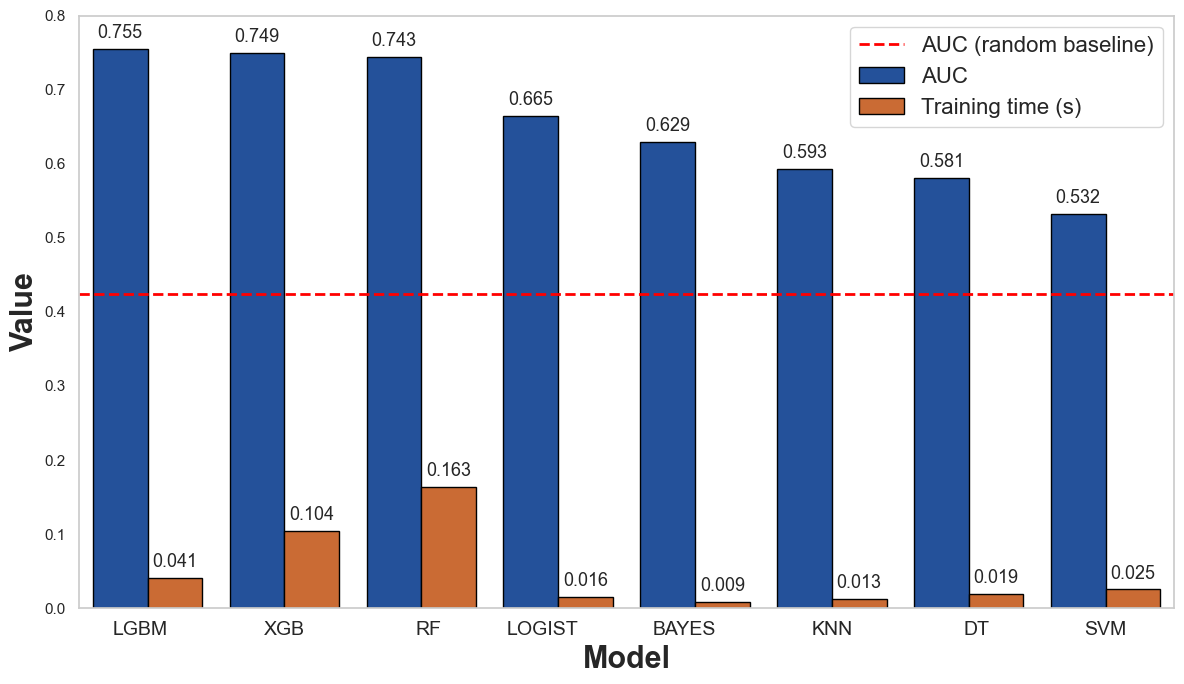

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D  # Para línea en leyenda

# Ordenar por AUC
results_df = results_df.sort_values(by='AUC', ascending=False)
ordered_models = results_df['Modelo'].tolist()

# Separar modelo 'Random' y guardar su valor AUC
random_row = results_df[results_df['Modelo'] == 'Random']
random_auc = random_row['AUC'].values[0] if not random_row.empty else None

# Eliminar 'Random' del DataFrame para el barplot
results_df_no_random = results_df[results_df['Modelo'] != 'Random']
ordered_models_no_random = [m for m in ordered_models if m != 'Random']

# Pasar a formato long
results_long = pd.melt(results_df_no_random, id_vars='Modelo', value_vars=['AUC', 'Training time (s)'],
                       var_name='Métrica', value_name='Valor')

# Plot settings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))

# Barplot sin 'Random'
ax = sns.barplot(data=results_long, x='Modelo', y='Valor', hue='Métrica',
                 palette=["#104CAE", "#E3641B"], edgecolor='black', order=ordered_models_no_random)

# Etiquetas de valor encima de cada barra
for p in ax.patches:
    height = p.get_height()
    if height < 0.0000001:
        continue
    ax.annotate(f'{height:.3f}' if height < 10 else f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=13, xytext=(0, 5),
                textcoords='offset points')

# Agregar línea roja discontinua si hay modelo Random
custom_legend = []
if random_auc is not None:
    ax.axhline(y=random_auc, color='red', linestyle='--', linewidth=2)
    # Línea para leyenda
    dashed_line_legend = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='AUC (random baseline)')
    custom_legend.append(dashed_line_legend)

# Ejes y leyenda
ax.set_xlabel('Model', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
plt.ylim(0, 0.8)
plt.xticks(ha='right', fontsize=14)

# Combinar leyendas
handles, labels = ax.get_legend_handles_labels()
if custom_legend:
    custom_legend += handles
ax.legend(handles=custom_legend, fontsize=16)

# Ajuste manual de las etiquetas del eje X
offset = 0.15  # Ajusta este valor hasta que veas los nombres centrados
ticks = ax.get_xticks()
ax.set_xticks([t + offset for t in ticks])

plt.tight_layout()
plt.grid(False)
plt.savefig("../img/ml_models.png", dpi=300, bbox_inches="tight")
plt.show()


## Best Model & Top 25

In [28]:
def compute_challenge_score(labels, outputs, hospitals):
    # Check the data.
    assert len(labels) == len(outputs)

    # Convert the data to NumPy arrays for easier indexing.
    labels = np.asarray(labels, dtype=np.float64)
    outputs = np.asarray(outputs, dtype=np.float64)

    # Identify the unique hospitals.
    unique_hospitals = sorted(set(hospitals))
    num_hospitals = len(unique_hospitals)

    # Initialize a confusion matrix for each hospital.
    tps = np.zeros(num_hospitals)
    fps = np.zeros(num_hospitals)
    fns = np.zeros(num_hospitals)
    tns = np.zeros(num_hospitals)

    # Compute the confusion matrix at each output threshold separately for each hospital.
    for i, hospital in enumerate(unique_hospitals):
        idx = [j for j, x in enumerate(hospitals) if x == hospital]
        current_labels = labels[idx]
        current_outputs = outputs[idx]
        num_instances = len(current_labels)

        # Collect the unique output values as the thresholds for the positive and negative classes.
        thresholds = np.unique(current_outputs)
        thresholds = np.append(thresholds, thresholds[-1]+1)
        thresholds = thresholds[::-1]
        num_thresholds = len(thresholds)

        idx = np.argsort(current_outputs)[::-1]

        # Initialize the TPs, FPs, FNs, and TNs with no positive outputs.
        tp = np.zeros(num_thresholds)
        fp = np.zeros(num_thresholds)
        fn = np.zeros(num_thresholds)
        tn = np.zeros(num_thresholds)

        tp[0] = 0
        fp[0] = 0
        fn[0] = np.sum(current_labels == 1)
        tn[0] = np.sum(current_labels == 0)

        # Update the TPs, FPs, FNs, and TNs using the values at the previous threshold.
        k = 0
        for l in range(1, num_thresholds):
            tp[l] = tp[l-1]
            fp[l] = fp[l-1]
            fn[l] = fn[l-1]
            tn[l] = tn[l-1]

            while k < num_instances and current_outputs[idx[k]] >= thresholds[l]:
                if current_labels[idx[k]] == 1:
                    tp[l] += 1
                    fn[l] -= 1
                else:
                    fp[l] += 1
                    tn[l] -= 1
                k += 1

        # Compute the FPRs.
        fpr = np.zeros(num_thresholds)
        for l in range(num_thresholds):
            if tp[l] + fn[l] > 0:
                fpr[l] = float(fp[l]) / float(tp[l] + fn[l])
            else:
                fpr[l] = float('nan')

        # Find the threshold such that FPR <= 0.05.
        max_fpr = 0.05
        if np.any(fpr <= max_fpr):
            l = max(l for l, x in enumerate(fpr) if x <= max_fpr)
            tps[i] = tp[l]
            fps[i] = fp[l]
            fns[i] = fn[l]
            tns[i] = tn[l]
        else:
            tps[i] = tp[0]
            fps[i] = fp[0]
            fns[i] = fn[0]
            tns[i] = tn[0]

    # Compute the TPR at FPR <= 0.05 for each hospital.
    tp = np.sum(tps)
    fp = np.sum(fps)
    fn = np.sum(fns)
    tn = np.sum(tns)

    if tp + fn > 0:
        max_tpr = tp / (tp + fn)
    else:
        max_tpr = float('nan')

    return max_tpr

In [87]:

from sklearn.metrics import f1_score

X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test = (
    prepare_datasets(
        X_clinical,
        df_features_classical_proc,
        df_features_fmm_proc,
        epoch_subset,
        filter_column="lastQ50+",
        block_size=4,
        N=3
    )
)
print(X_train_val.shape, y_train_val.shape, groups_train_val.shape)
pipeline = create_pipeline(X_train_val)
pipeline.fit(X_train_val, y_train_val)

(40200, 15)
(32820, 15)
(354, 51) (354,) (354,)


d:\MSc - AI\Thesis\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['age', 'rosc', 'ohca', 'sr', 'ttm', 'ENT_perm_mean', 'ENT_perm_sd',
       'ENT_spectral_mean', 'ENT_spectral_sd', 'ENT_svd_mean', 'ENT_svd_sd',
       'FRC_higuchi_mean', 'FRC_higuchi_sd', 'FRC_petrosian_mean',
       'FRC_petrosian_sd'...
       'n_epochs', 'FMM_A_me_mean', 'FMM_A_me_sd', 'FMM_ω_mean', 'FMM_ω_sd',
       'FMM_R2_median', 'FMM_A_me_cv', 'FMM_ω_cv', 'FMM_α_circmean',
       'FMM_α_circsd', 'FMM_α_circcv', 'FMM_ω_proplt001'],
      dtype='object'))])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5450311443835689,
                                learning_rate=0.2652832417281156, max_depth=10,
                                n_estimators=200, n_jobs=10, num_leaves=64,
                                random_state=42, subsample=0.921136265542184,
                                verbose=-1))])

hour_block
4      2.506784
8     10.841194
12    15.919369
16    19.679545
20    24.098721
24    26.954387
Name: proportion, dtype: float64


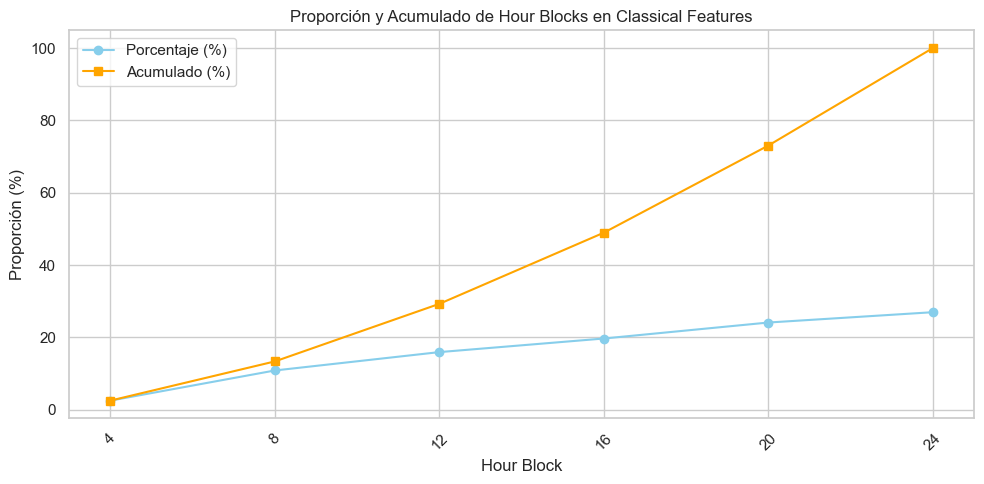

In [30]:
df_features_classical_proc2 = df_features_classical_proc.copy()
hour = df_features_classical_proc2["hour"]
hour_block = (hour // 4) * 4 + 4
df_features_classical_proc2["hour_block"] = hour_block
props = df_features_classical_proc2["hour_block"].value_counts(normalize=True).sort_index() * 100
print(props)
cumsum = props.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(props.index, props.values, marker='o', label='Porcentaje (%)', color='skyblue')
plt.plot(cumsum.index, cumsum.values, marker='s', label='Acumulado (%)', color='orange')
plt.xlabel('Hour Block')
plt.ylabel('Proporción (%)')
plt.title('Proporción y Acumulado de Hour Blocks en Classical Features')
plt.xticks(props.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
df_features_classical_proc["hour"].value_counts(normalize=True)*100

hour
23    8.295645
21    7.959685
19    7.843391
17    7.287763
15    6.525391
22    5.969764
13    5.775940
11    5.633803
18    4.780979
20    4.729293
7     4.470862
9     4.432097
16    4.186587
14    4.173666
10    3.540509
12    3.204548
6     2.933196
5     2.351725
8     2.312960
3     2.080372
4     1.085412
2     0.348882
1     0.051686
0     0.025843
Name: proportion, dtype: float64

In [88]:

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
final_model_auc = roc_auc_score(y_test, y_pred_proba)
final_model_cs = compute_challenge_score(y_test, y_pred_proba, groups_test)
final_model_f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
final_model_accuracy = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))

print(f"PROPOSED ROC AUC: {final_model_auc:.3f}")
print(f"PROPOSED Challenge Score: {final_model_cs:.3f}")
print(f"PROPOSED F1 Score: {final_model_f1:.3f}")
print(f"PROPOSED Accuracy: {final_model_accuracy:.3f}")


# Entrena el pipeline completo
pipeline.fit(X_train_val, y_train_val)

# Obtiene el modelo final del pipeline (ajusta si estás usando una estructura más compleja)
final_model = pipeline.named_steps['classifier']  # Ajusta el nombre según tu pipeline

# Obtiene los nombres de features transformadas
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names = [s.split("__", 1)[1] if "__" in s else s for s in feature_names]
# Obtiene las importancias (esto depende del modelo)
importances = final_model.feature_importances_

# Crea un diccionario ordenado con las features más importantes
feature_importance = dict(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True))

PROPOSED ROC AUC: 0.868
PROPOSED Challenge Score: 0.718
PROPOSED F1 Score: 0.823
PROPOSED Accuracy: 0.744


In [33]:
data24 = pd.read_csv(DATA_FOLDER + "official_scores_24.tsv", sep="\t", header=1)
data24 = data24[["Team", "Outcome AUROC on the test set",'Challenge Score on the test set',
                 'Outcome F-measure on the test set', 'Outcome Accuracy on the test set']].iloc[0:30,:]
# Insert a new row at the beginning with the PROPOSED's scores
new_row = pd.DataFrame({
    "Team": ["PROPOSED"],
    "Outcome AUROC on the test set": [final_model_auc],
    "Challenge Score on the test set": [final_model_cs],
    "Outcome F-measure on the test set": [final_model_f1],
    "Outcome Accuracy on the test set": [final_model_accuracy]
})
data24 = pd.concat([new_row, data24], ignore_index=True)
data24 = round(data24, 3)
data24.columns = ["Team", "AUC", "CS", "F1", "ACC"]
data24.to_csv("scores_24h.csv", index=False)
display(data24)

,Team,AUC,CS,F1,ACC
0,PROPOSED,0.868,0.718,0.823,0.744
1,AIrhythm,0.864,0.649,0.728,0.781
2,TUD_EEG,0.865,0.644,0.254,0.340
3,ComaToss,0.814,0.589,0.670,0.680
4,MIWEAR,0.801,0.554,0.493,0.693
5,PKU_NIHDS,0.808,0.525,0.664,0.673
6,The BEEGees,0.827,0.520,0.746,0.781
7,MetaHeart_YNNU,0.748,0.485,0.496,0.686
8,WesternUni,0.795,0.480,0.744,0.784
9,Blue and Gold,0.741,0.465,0.632,0.693


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(data24, metric):
    data24 = data24.copy()
    data24 = data24.sort_values(by=metric, ascending=False)
    
    # Set Seaborn whitegrid e
    sns.set(style="whitegrid")

    # Set custom colors: highlight 'PROPOSED'
    colors = ['#ff7f0e' if team == 'PROPOSED' else '#1f77b4' for team in data24['Team']]

    # Create the plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(data24['Team'], data24[metric], color=colors, edgecolor='black')

    # Add labels and title
    plt.xlabel('Study', fontsize=22)
    plt.ylabel(metric, fontsize=22)
    plt.xticks(rotation=45, ha='right')
    # increase x and y tick size
    plt.tick_params(axis='both', which='major', labelsize=12)
    # set y ticks step to 0.1
    plt.yticks(np.arange(0, round(max(data24[metric])+0.05, 1), 0.1), fontsize=12)

    # Only horizontal gridlines
    ax = plt.gca()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', visible=False)

    # Tidy up layout
    plt.tight_layout()
    plt.savefig(f"../img/metric_{metric}.png", dpi=300, bbox_inches="tight")
    plt.show()

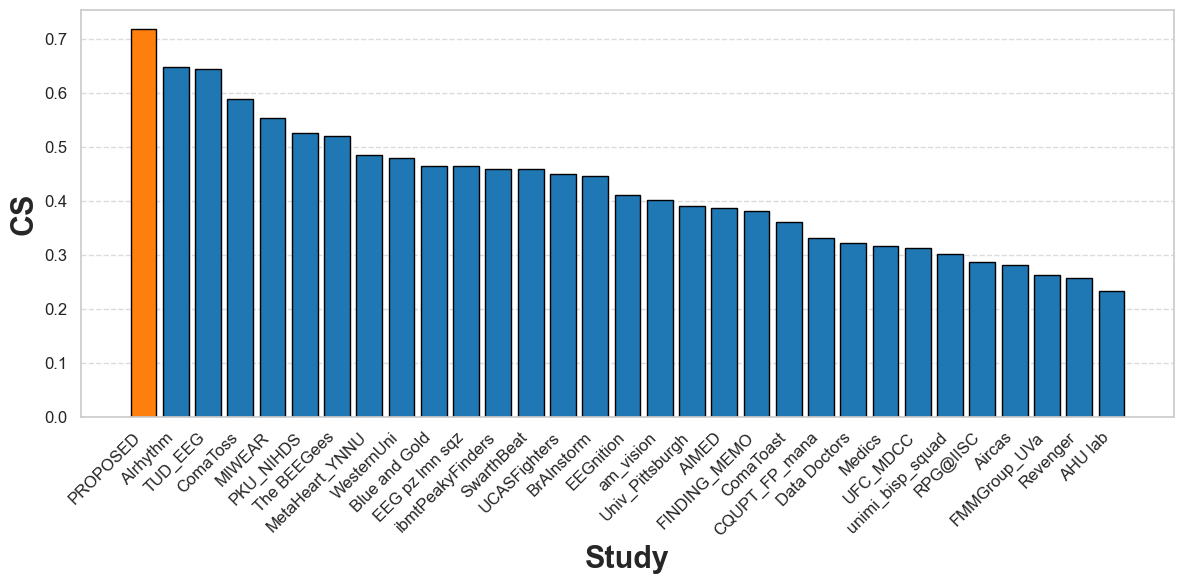

In [89]:
plot_metric(data24, "CS")

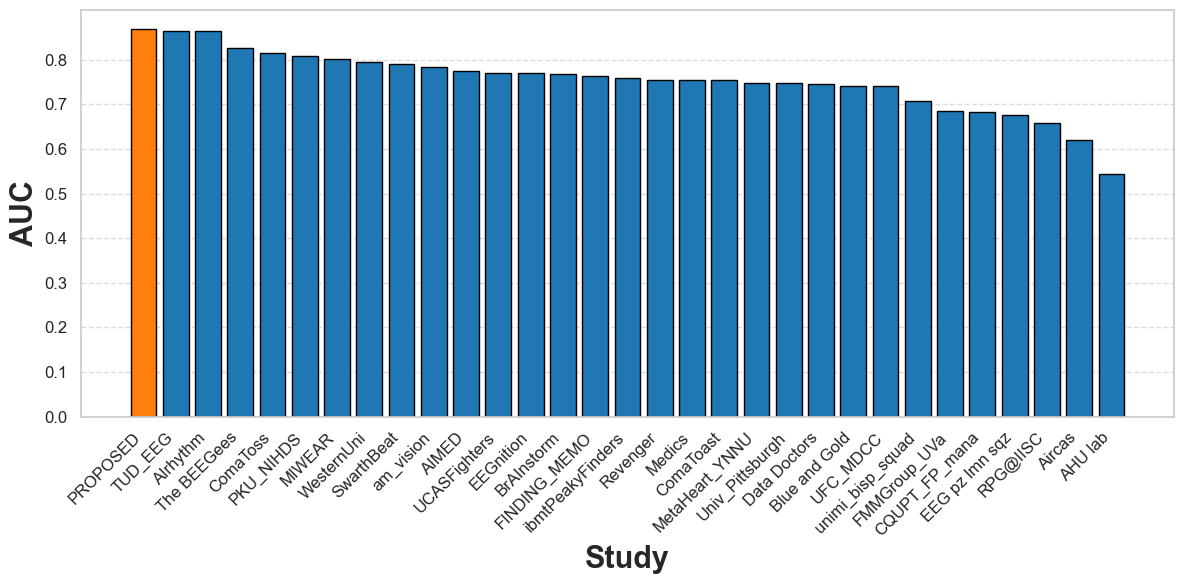

In [77]:
plot_metric(data24, "AUC")

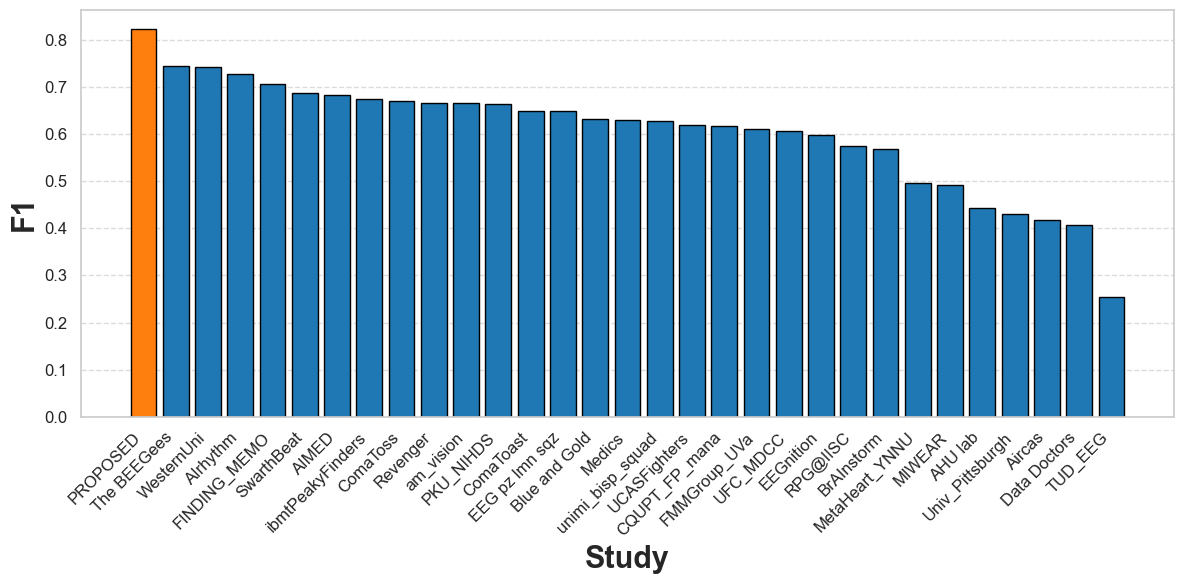

In [79]:
plot_metric(data24, "F1")

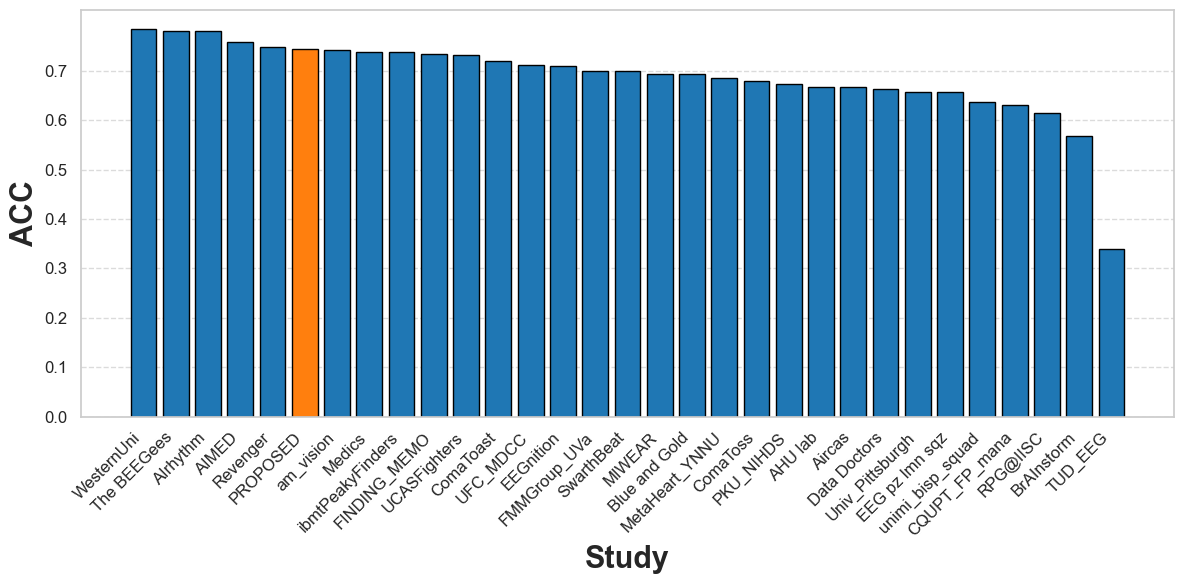

In [80]:
plot_metric(data24, "ACC")

# Top 5 table

In [39]:
data24.sort_values(by="AUC", ascending=False).iloc[0:6,:]

,Team,AUC,CS,F1,ACC
0,PROPOSED,0.868,0.718,0.823,0.744
2,TUD_EEG,0.865,0.644,0.254,0.340
1,AIrhythm,0.864,0.649,0.728,0.781
6,The BEEGees,0.827,0.520,0.746,0.781
3,ComaToss,0.814,0.589,0.670,0.680
5,PKU_NIHDS,0.808,0.525,0.664,0.673


# Feature Importance

In [90]:
importances = pipeline.named_steps['classifier'].feature_importances_

feature_names = X_train_val.columns

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_grouped_importances_classification(pipeline, feature_names, infixes, path):
    if hasattr(pipeline.named_steps["classifier"], "feature_importances_"):
        importances = pipeline.named_steps["classifier"].feature_importances_
        df_feature_imp = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).set_index("feature")

        total_importance = df_feature_imp["importance"].sum()

        grouped_importances = []
        other_importance = 0  # para acumular importancia de 'Other'

        # Definir lista de infijos sin 'Other'
        real_infixes = [inf for inf in infixes if inf != "Other"]

        for infix in real_infixes:
            group_importance = df_feature_imp[df_feature_imp.index.str.contains(infix)]["importance"].sum()
            grouped_importances.append({
                "Feature": infix,
                "Importance": group_importance / total_importance * 100
            })

        # Si 'Other' está en los infijos, calculamos su importancia
        if "Other" in infixes:
            # Construir una máscara booleana: True para las features que NO contienen ninguno de los infijos
            mask_other = ~df_feature_imp.index.str.contains('|'.join(real_infixes))
            other_importance = df_feature_imp[mask_other]["importance"].sum()
            grouped_importances.append({
                "Feature": "Other",
                "Importance": other_importance / total_importance * 100
            })

        df_grouped = pd.DataFrame(grouped_importances)
        df_grouped = df_grouped.sort_values(by="Importance", ascending=True)

        # Gráfico con Seaborn
        sns.set(style="whitegrid")
        plt.figure(figsize=(8, 5))
        
        ax = sns.barplot(
            x="Importance",
            y="Feature",
            data=df_grouped,
            palette="viridis"
        )
        ax.set_xlabel("Importance (%)", fontsize=18)
        ax.set_ylabel("Feature subset", fontsize=18)
        # set x and y ticks fontsize to 14
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # set y lim between 0 and 40
        plt.xlim(0, 40)

        # Mostrar valores en las barras
        for i, v in enumerate(df_grouped["Importance"]):
            ax.text(v + 0.3, i, f"{v:.1f}%", color="black", va="center", fontsize=12)

        plt.tight_layout()
        plt.savefig(path, dpi=300, bbox_inches="tight")
        plt.show()

    else:
        raise AttributeError("El clasificador no tiene feature_importances_.")




In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_grouped_importances_classification(pipeline, feature_names, infixes, path, ylabel, plot=True, max_x=40):
    importances = pipeline.named_steps["classifier"].feature_importances_
    df_feature_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).set_index("feature")

    grouped_importances = []
    other_importance = 0  # para acumular importancia de '"C&D"'

    # Definir lista de infijos sin '"C&D"'
    real_infixes = [inf for inf in infixes if inf != "C&D"]

    for infix in real_infixes:
        group_importance = df_feature_imp[df_feature_imp.index.str.contains(infix)]["importance"].sum()
        grouped_importances.append({
            "Feature": infix,
            "Importance": group_importance
        })

    # Si 'Other' está en los infijos, calculamos su importancia
    if "C&D" in infixes:
        # Construir una máscara booleana: True para las features que NO contienen ninguno de los infijos
        mask_other = ~df_feature_imp.index.str.contains('|'.join(real_infixes))
        other_importance = df_feature_imp[mask_other]["importance"].sum()
        grouped_importances.append({
            "Feature": "C&D",
            "Importance": other_importance
        })

    df_grouped = pd.DataFrame(grouped_importances)

    # Normalizar para que la suma sea 100%
    total_grouped = df_grouped["Importance"].sum()
    if total_grouped > 0:
        df_grouped["Importance"] = df_grouped["Importance"] / total_grouped * 100
    else:
        df_grouped["Importance"] = 0

    df_grouped = df_grouped.sort_values(by="Importance", ascending=True)

    if not plot:
        return df_grouped

    # Gráfico con Seaborn
    #sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))

    ax = sns.barplot(
        x="Importance",
        y="Feature",
        data=df_grouped,
        palette="viridis",
        edgecolor="black",
        linewidth=1.5
    )
    ax.set_xlabel("Importance (%)", fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, max_x)

    # Mostrar valores en las barras
    for i, v in enumerate(df_grouped["Importance"]):
        ax.text(v + 0.3, i, f"{v:.1f}%", color="black", va="center", fontsize=12)

    plt.tight_layout()
    plt.grid(False)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    # remove the grid
    plt.show()
    return None

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_21144\3358333957.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


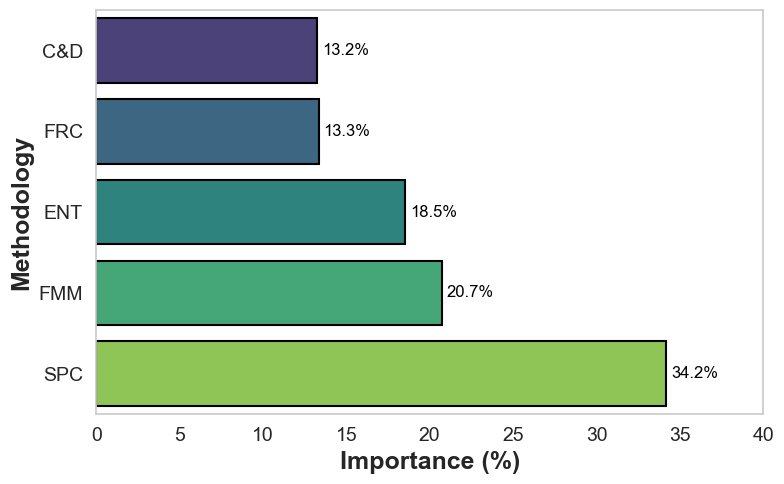

In [93]:
# Ejemplo de uso
get_grouped_importances_classification(pipeline, X_train_val.columns, ["FMM", "ENT", "SPC", "FRC", "C&D"], "../img/fi_subset.png", "Methodology", max_x = 40)

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_21144\3358333957.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


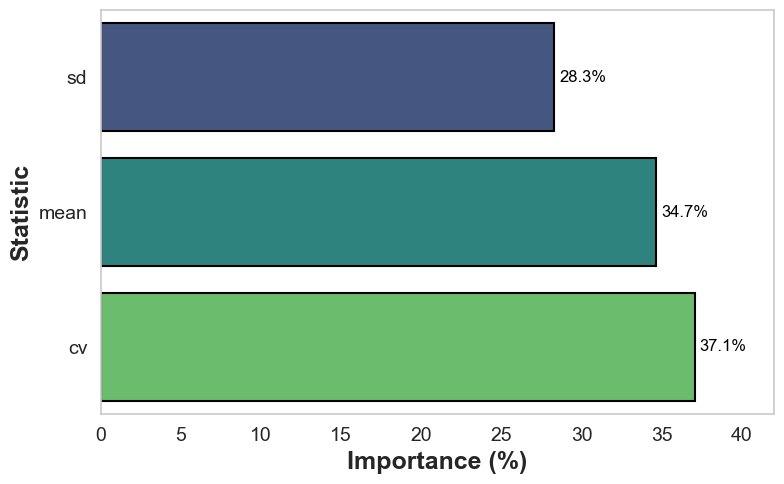

In [94]:
get_grouped_importances_classification(pipeline, X_train_val.columns, ["mean", "sd", "cv"], "../img/fi_stat.png", "Statistic", max_x = 42)

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_grouped_importances_classification_fine(pipeline, feature_names, max_x = 40):
    if hasattr(pipeline.named_steps["classifier"], "feature_importances_"):
        importances = pipeline.named_steps["classifier"].feature_importances_
        df_feature_imp = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        })

        # Filtrar features que tienen al menos 2 underscores
        df_feature_imp = df_feature_imp[df_feature_imp["feature"].str.count('_') >= 2].copy()

        # Extraer el prefijo fijo del medio: primera y segunda parte unidas por '_'
        def get_prefix_mid(name):
            parts = name.split('_')
            if len(parts) >= 2:
                return parts[0] + "_" + parts[1]
            else:
                return name  # fallback

        df_feature_imp["group"] = df_feature_imp["feature"].apply(get_prefix_mid)

        # Agrupar por 'group' y sumar importancias
        df_grouped = df_feature_imp.groupby("group")["importance"].sum().reset_index()

        # Normalizar importancias al total de las features filtradas
        total_importance = df_grouped["importance"].sum()
        df_grouped["Importance"] = df_grouped["importance"] / total_importance * 100 if total_importance > 0 else 0
        print(df_grouped["Importance"].sum())
        df_grouped = df_grouped.sort_values(by="Importance", ascending=True)

        sns.set(style="whitegrid")
        plt.figure(figsize=(8, 6))

        ax = sns.barplot(
            x="Importance",
            y="group",
            data=df_grouped,
            palette="viridis",
            edgecolor="black",
            linewidth=1.5
        )
        ax.set_xlabel("Importance (%)", fontsize=18)
        ax.set_ylabel("Feature variant", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlim(0, max_x)

        # Mostrar valores en las barras
        for i, v in enumerate(df_grouped["Importance"]):
            ax.text(v + 0.3, i, f"{v:.1f}%", color="black", va="center", fontsize=12)

        plt.tight_layout()
        plt.grid(False)
        plt.savefig("../img/fi_group.png", dpi=300, bbox_inches="tight")
        plt.show()

    else:
        raise AttributeError("El clasificador no tiene feature_importances_.")


100.0


C:\Users\Adolfo\AppData\Local\Temp\ipykernel_21144\4256861291.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


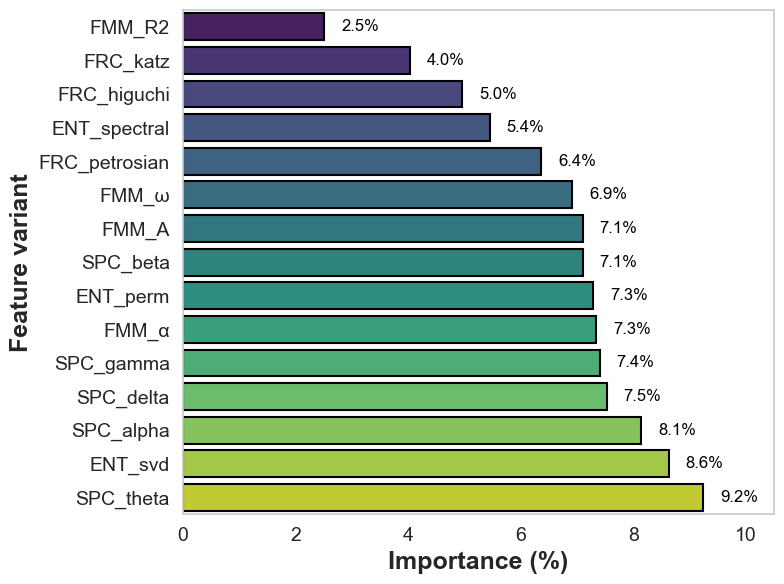

In [95]:
get_grouped_importances_classification_fine(pipeline, X_train_val.columns, max_x = 10.5)

d:\MSc - AI\Thesis\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\MSc - AI\Thesis\venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\Adolfo\AppData\Local\Temp\ipykernel_21144\3989401349.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


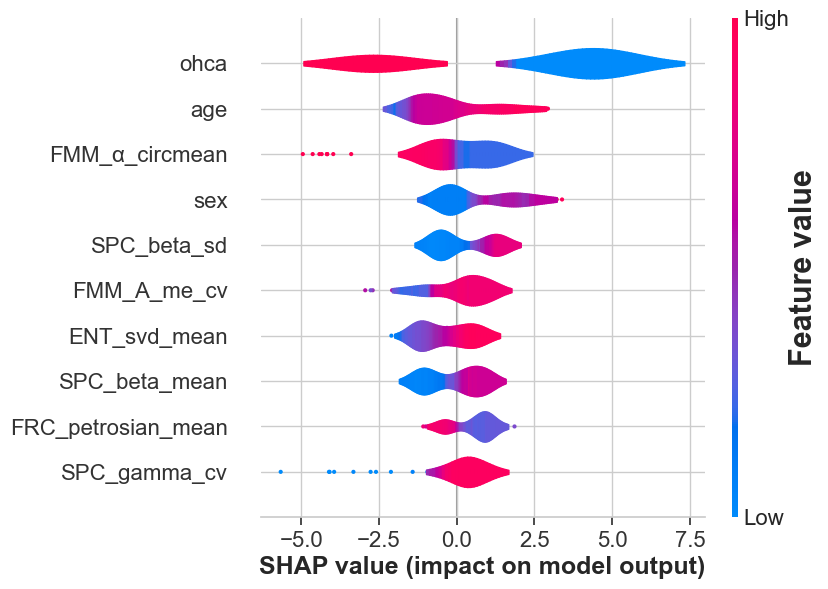

In [101]:
# Asumimos pipeline ya entrenado con pipeline.fit(X_train, y_train)

import shap
import pandas as pd
import matplotlib.pyplot as plt

# Preprocesamos X_test con el preprocessor del pipeline
X_test_encoded = pd.DataFrame(
    pipeline.named_steps["preprocessor"].transform(X_test),
    columns=X_test.columns  # Aquí puedes mantener los nombres si no cambian
)

# Creamos el explainer
explainer = shap.TreeExplainer(pipeline.named_steps["classifier"])

# Obtenemos los shap values
shap_values = explainer.shap_values(X_test_encoded)

# Si binaria, puede ser lista de dos, o array directamente
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Graficamos
shap.summary_plot(
    shap_values_to_plot,
    X_test_encoded,
    plot_type="violin",
    max_display=10,
    show=False
)

# Ajustes estéticos
plt.gcf().set_size_inches(8, 6)
plt.gca().tick_params(labelsize=16)
plt.xlabel(plt.gca().get_xlabel(), fontsize=18)
plt.ylabel(plt.gca().get_ylabel(), fontsize=18)

# Colorbar (si existe)
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)
cbar.set_ylabel(cbar.get_ylabel(), fontsize=22)

for text in plt.gcf().findobj(match=plt.Text):
    if text.get_text() in ["High", "Low"]:
        text.set_fontsize(16)

# Guardamos
plt.savefig(f"../img/shap_global.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt

def get_local_shap_plot(instance_index, path):
    model = pipeline.named_steps["classifier"]
    X_test_transformed = pipeline[:-1].transform(X_test)

    # Obtener nombres de features tras el preprocesamiento
    feature_names = pipeline[:-1].get_feature_names_out()
    # Si quieres, quita prefijos así:
    feature_names = [name.replace("num__", "") for name in feature_names]

    explainer = shap.TreeExplainer(model, X_test_transformed, model_output="probability")
    shap_values_all = explainer(X_test_transformed)

    shap_vals_instance = shap_values_all[instance_index]

    shap_values = shap.Explanation(
        values=shap_vals_instance.values,
        base_values=shap_vals_instance.base_values,
        data=X_test_transformed[instance_index],
        feature_names=feature_names
    )

    # Genera el gráfico waterfall y obtiene la figura actual
    shap.plots.waterfall(shap_values)
    #plt.savefig(path, dpi=300, bbox_inches="tight")

    plt.show()

In [ ]:
# get_local_shap_plot(instance_index=6, path="../img/shap_local_bad.png")

In [ ]:
results_df.tail(20)

,seed,max_hours,AUC,CS,F1,ACC
160,296,20,0.756047,0.418367,0.805687,0.730263
161,296,24,0.852415,0.705128,0.813953,0.735537
162,3430,4,0.703893,0.204082,0.788732,0.703947
163,3430,8,0.717120,0.183673,0.790909,0.697368
164,3430,12,0.708995,0.244898,0.788732,0.703947
165,3430,16,0.730159,0.234694,0.779817,0.684211
166,3430,20,0.760204,0.377551,0.796296,0.710526
167,3430,24,0.838402,0.641026,0.770950,0.661157
168,2893,4,0.705593,0.244898,0.792453,0.710526
169,2893,8,0.722978,0.214286,0.794393,0.710526


# Time analysis

In [97]:
SEEDS = [42, 14, 301, 104, 213, 639, 899, 530, 569, 124, 178, 147, 948, 806, 34, 867, 
         76, 590, 462, 465, 754, 886, 477, 4039, 3280, 1225, 296, 3430, 2893, 4346]

SEEDS = [42]

results = []
importances_list = []

for seed in tqdm(SEEDS):
    np.random.seed(seed)
    
    for max_hours in range(4, 25, 4):
        X_train_val, y_train_val, groups_train_val, X_test, y_test, groups_test = (
            prepare_datasets(
                X_clinical,
                df_features_classical_proc,
                df_features_fmm_proc,
                epoch_subset,
                filter_column="lastQ50+",
                block_size=4,
                N=3,
                max_hours=max_hours,
            )
        )

        pipeline = create_pipeline(X_train_val, random_state=seed)
        pipeline.fit(X_train_val, y_train_val)

        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        final_model_auc = roc_auc_score(y_test, y_pred_proba)
        final_model_cs = compute_challenge_score(y_test, y_pred_proba, groups_test)
        final_model_f1 = f1_score(y_test, (y_pred_proba > 0.5).astype(int))
        final_model_accuracy = accuracy_score(y_test, (y_pred_proba > 0.5).astype(int))

        results.append({
            "seed": seed,
            "max_hours": max_hours,
            "AUC": final_model_auc,
            "CS": final_model_cs,
            "F1": final_model_f1,
            "ACC": final_model_accuracy
        })

        importances_df = get_grouped_importances_classification(
            pipeline,
            X_train_val.columns,
            ["FMM", "ENT", "SPC", "FRC", "C&D"],
            None,
            "Methodology",
            plot=False
        )
        importances_df["max_hours"] = max_hours
        importances_df["seed"] = seed
        importances_list.append(importances_df)

results_df = pd.DataFrame(results)
results_long = results_df.melt(
    id_vars=["seed", "max_hours"],
    var_name="Metric",
    value_name="Score"
)

# Concatenar importancias de todas las semillas y max_hours
importances_all_df = pd.concat(importances_list, ignore_index=True)

  0%|          | 0/1 [00:00<?, ?it/s]

(40200, 15)
(32820, 15)
(40200, 15)
(32820, 15)
(40200, 15)
(32820, 15)
(40200, 15)
(32820, 15)
(40200, 15)
(32820, 15)
(40200, 15)
(32820, 15)


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


<Figure size 1000x600 with 0 Axes>

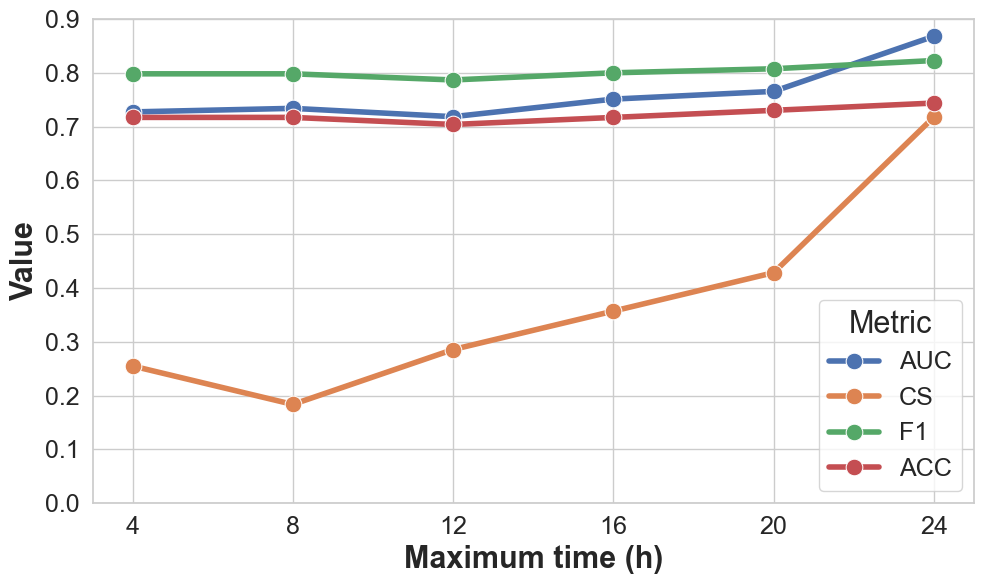

In [98]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=results_long,
    x="max_hours",
    y="Score",
    hue="Metric",
    estimator="mean",
    errorbar=('ci', 95),  # reemplaza el ci deprecado
    marker="o",           # añade puntos
    markersize=12,         # tamaño de puntos
    linewidth=4
)

plt.xlabel("Maximum time (h)", fontsize=22)
plt.ylabel("Value", fontsize=22)
plt.legend(title="Metric", fontsize=18, title_fontsize='22')
plt.xticks(range(4, 25, 4), fontsize=14)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 0.9)
plt.tight_layout()
plt.savefig("../img/evolution_performance.png", dpi=300, bbox_inches="tight")
plt.show()

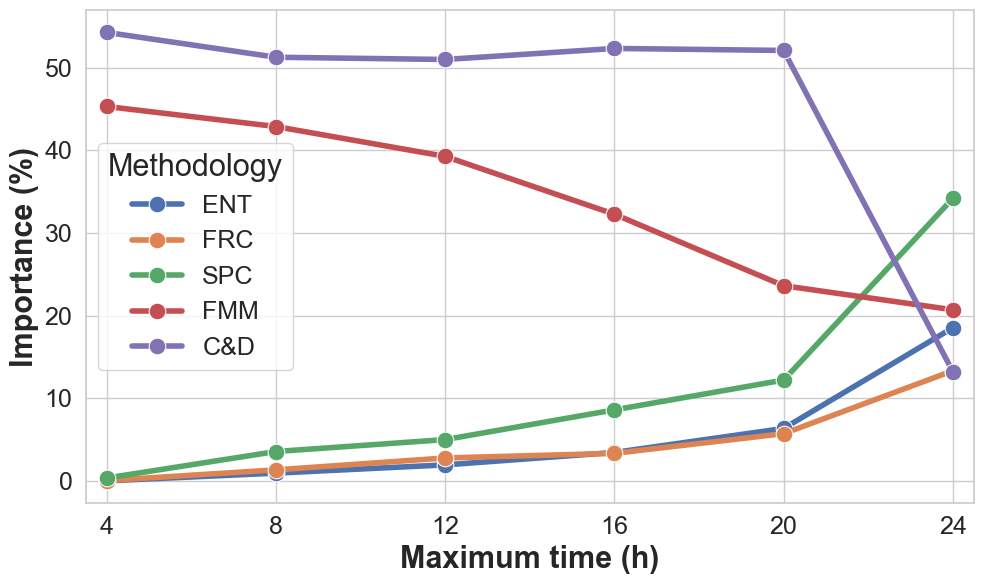

In [99]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=importances_all_df,
    x="max_hours",
    y="Importance",
    hue="Feature",           # o "Methodology" si corresponde
    estimator="mean",        # promedio para suavizar
    errorbar=('ci', 95),     # banda de confianza 95%
    marker="o",              # puntos grandes
    markersize=12,
    linewidth=4
)

plt.xlabel("Maximum time (h)", fontsize=22)
plt.ylabel("Importance (%)", fontsize=22)
plt.legend(title="Methodology", fontsize=18, title_fontsize='22')  # Ajusta título según hue
plt.xticks(range(4, 25, 4), fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(3.5, 24.5)
plt.tight_layout()
plt.savefig("../img/evolution_importances.png", dpi=300, bbox_inches="tight")
plt.show()


## Hyperparameter tuning

In [218]:
from sklearn.base import BaseEstimator
import yaml


def replace_none_strings(d):
    if isinstance(d, dict):
        return {k: replace_none_strings(v) for k, v in d.items()}
    elif isinstance( d, list):
        return [replace_none_strings(i) for i in d]
    elif d == "None":
        return None
    else:
        return d


def hyperparameter_tuning(
    estimator: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
    name_prefix: str,
) -> None:

    wandb.init()
    config = wandb.config

    estimator.set_params(
        classifier__n_estimators=config.n_estimators,
        classifier__max_depth=config.max_depth,
        classifier__learning_rate=config.learning_rate,
        classifier__subsample=config.subsample,
        classifier__colsample_bytree=config.colsample_bytree,
        classifier__num_leaves=config.num_leaves,
    )

    estimator.fit(X_train, y_train)

    y_pred = estimator.predict_proba(X_val)[:, 1]
    macro_auc = roc_auc_score(y_val, y_pred)
    del y_pred
    wandb.log({"macro_auc": macro_auc})

    # model.save(name_prefix, X_test, y_test, lh_test)
    del estimator